In [1]:
import sys
import climin
from functools import partial
import warnings
import os
sys.path.append('..')

import numpy as np
from scipy.stats import multinomial
from scipy.linalg.blas import dtrmm

import GPy
from GPy.util import choleskies
from GPy.core.parameterization.param import Param
from GPy.kern import Coregionalize
from GPy.likelihoods import Likelihood
from GPy.util import linalg

from likelihoods.bernoulli import Bernoulli
from likelihoods.gaussian import Gaussian
from likelihoods.poisson import Poisson

from likelihoods.hetgaussian import HetGaussian

from hetmogp.util import draw_mini_slices
from hetmogp.het_likelihood import HetLikelihood
from hetmogp.svmogp import SVMOGP
from hetmogp import util
from hetmogp.util import vem_algorithm as VEM

import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import rc, font_manager
from matplotlib import rcParams

warnings.filterwarnings("ignore")

from GPy.util.misc import safe_exp
from GPy import kern

from sklearn.cluster import KMeans

import random

In [2]:
X1_train = np.load('./synthetic_data/X1_train_syn.npy')
X2_train = np.load('./synthetic_data/X2_train_syn.npy')
Y1_train = np.load('./synthetic_data/Y1_train_syn.npy')
Y2_train = np.load('./synthetic_data/Y2_train_syn.npy')
X1test = np.load('./synthetic_data/X_test_syn.npy')
Y1test = np.load('./synthetic_data/Y_test_syn.npy')
Z = np.load('./synthetic_data/Z_syn.npy')

In [3]:
M = 100  # number of inducing points
Q = 1  # number of latent functions
l = 4.0
v_q = 1

# Heterogeneous Likelihood Definition
likelihoods_list = [Poisson()] 
likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()
D = likelihood.num_output_functions(Y_metadata)

W_list, _ = util.random_W_kappas(Q, D, rank=1, experiment=True)

In [4]:
# KERNELS
input_dim = 3

ls_q = np.array(([l]*Q))
var_q = np.array(([v_q]*Q))
kern_list = util.latent_functions_prior(Q, lenghtscale=ls_q, variance=var_q, input_dim=input_dim)

In [5]:
X = [X1_train]
Y = [Y1_train]

In [6]:
step_rate = 0.01
mode = "adam"

if mode == "adam":
    model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata, batch_size=150)
    model.Z.fix()
    print("which mode:\n", mode)
    max_iter = 1000
    def callback(i):
        # global max_iter
        if i['n_iter'] % 50 == 0:
            print('svi - iteration '+ str(i['n_iter'])+'/' + str(int(max_iter)) + str(model.log_likelihood()))

        if i['n_iter'] > max_iter:
            return True
        return False

    opt = climin.Adam(model.optimizer_array, model.stochastic_grad, step_rate=step_rate, 
                decay_mom1=1 - 0.9, decay_mom2=1 - 0.999)
    opt.minimize_until(callback)

elif mode == "vem":        
    print("which mode:\n", mode)
    model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata)
    model = VEM(model, vem_iters=10, maxIter_perVEM=100, optZ=False, verbose=False,verbose_plot=False,non_chained=True)
    model.kern_q0.variance.fix()
#     model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood,Y_metadata=Y_metadata, batch_size=30)
#     model = VEM(model, vem_iters=30, maxIter_perVEM=100, step_rate=step_rate, optZ=False, verbose=True, verbose_plot=False)

which mode:
 adam
svi - iteration 50/1000[[-530.79598275]]
svi - iteration 100/1000[[-406.90272871]]
svi - iteration 150/1000[[-363.45208413]]
svi - iteration 200/1000[[-339.98805796]]
svi - iteration 250/1000[[-328.07267344]]
svi - iteration 300/1000[[-322.95477695]]
svi - iteration 350/1000[[-320.82677013]]
svi - iteration 400/1000[[-319.92917758]]
svi - iteration 450/1000[[-319.54872332]]
svi - iteration 500/1000[[-319.39691053]]
svi - iteration 550/1000[[-319.34496013]]
svi - iteration 600/1000[[-319.33275921]]
svi - iteration 650/1000[[-319.33300944]]
svi - iteration 700/1000[[-319.3342831]]
svi - iteration 750/1000[[-319.33270149]]
svi - iteration 800/1000[[-319.32775139]]
svi - iteration 850/1000[[-319.32019336]]
svi - iteration 900/1000[[-319.31107781]]
svi - iteration 950/1000[[-319.30134013]]
svi - iteration 1000/1000[[-319.29167879]]


model:
 
Name : SVMOGP
Objective : 273.0394174184195
Number of Parameters : 5454
Number of Optimization Parameters : 5154
Updates : True
Parameters:
  SVMOGP.              |                   value  |  constraints  |  priors
  inducing_inputs      |                (100, 3)  |     fixed     |        
  m_u                  |                (100, 1)  |               |        
  L_u                  |               (5050, 1)  |               |        
  kern_q0.variance     |      1.2499084186527034  |      +ve      |        
  kern_q0.lengthscale  |       3.626884787694605  |      +ve      |        
  B_q0.W               |           [-0.80724708]  |               |        
  B_q0.kappa           |  5.562684646268137e-309  |      +ve      |        


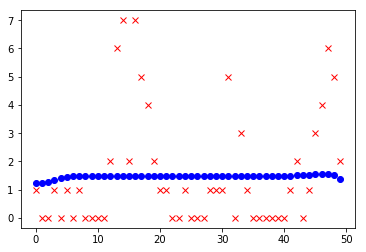

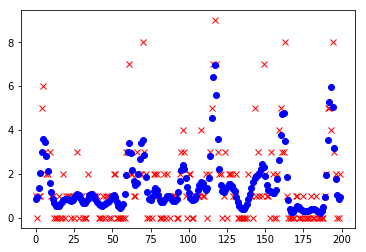

In [7]:
mu_pred, var_pred = model.predict(X1test)
posteriors = model.posteriors_F(X1test)
mu_fstar, var_fstar = posteriors[0].mean.copy(), np.diag(posteriors[0].covariance.copy())[:, None]

plt.figure()

# plt.title("Test")
plt.plot(Y1test, 'rx')

# plt.title("Train")
plt.plot(mu_pred[0], 'bo')

mu_pred_train, var_pred_train = model.predict(X[0])
posteriors_ = model.posteriors_F(X[0])
mu_fstar_train, var_fstar_train = posteriors_[0].mean.copy(), np.diag(posteriors_[0].covariance.copy())[:, None]

plt.figure()
plt.plot(Y[0], 'rx')
plt.plot(mu_pred_train[0], 'bo')

# np.save('toy_data_gp_params.npy', model.param_array)
print("model:\n", model)

In [8]:
X1_train_slice1 = X[0][:131].copy()
Y1_train_slice1 = Y[0][:131].copy()
X1_train_slice2 = X[0][131:].copy()
Y1_train_slice2 = Y[0][131:].copy()

In [9]:
values = mu_pred[0].copy()
values = np.floor(values)

In [10]:
values_train = mu_pred_train[0].copy()
values_train = np.floor(values_train)

Text(0, 0.5, 'Count')

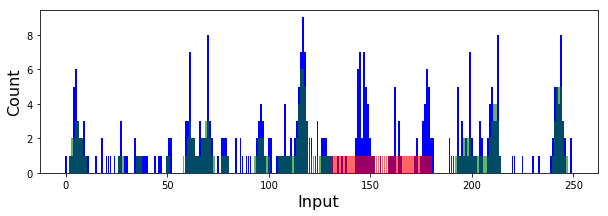

In [11]:
plt.figure(figsize=(10,3))
plt.bar([i for i in range(0, 131)], Y1_train_slice1.reshape((-1,)), color='b', width=0.9)
plt.bar([i for i in range(131, 181)], Y1test.reshape((-1,)), color='b', width=0.9)
plt.bar([i for i in range(181, 250)], Y1_train_slice2.reshape((-1,)), color='b', width=0.9)

plt.bar([i for i in range(0, 131)], values_train[:131].reshape((-1,)), color='g', width=0.9, alpha=0.6)
plt.bar([i for i in range(131, 181)], values.reshape((-1,)), color='r', width=0.9, alpha=0.6)
plt.bar([i for i in range(181, 250)], values_train[131:].reshape((-1,)), color='g', width=0.9, alpha=0.6)

plt.xlabel("Input", fontsize=16)
plt.ylabel("Count", fontsize=16)
